# 7. ML Comparisons - Part 2
In part 2, I wanted to balance all categories so that every single one of them has approxemately the same anmount of descriptions. Now, drugs is very biased. By doing this, I hope to get better results. 

We specify how many descriptions we want to have as a minimum for each category: 'min_records_per_category'. Then, all categories that have less than that are dropped and for each of the remaining categories, exactly that amount is used so that we have all categories of same lenght with minimum amount of descriptions. 

In [1]:
import pandas as pd
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessing import PreProcessor

pp = PreProcessor()

data = pd.read_csv('darkweb/data/agora.csv')

min_records_per_category = 500

unique_categories = data[' Category'].unique()
sorteddf = data.sort_values([' Category']).groupby(' Category').head(min_records_per_category)
filtereddf = sorteddf.where(sorteddf[" Category"].isin(unique_categories))
filtereddf = filtereddf[filtereddf["Vendor"].notnull()]
filtereddf = filtereddf[~filtereddf[' Category'].str.contains('Other')]
filtereddf = filtereddf[~filtereddf[' Category'].str.contains('Information')]

categories = filtereddf[' Category']
descriptions = filtereddf[' Item'] + " " + filtereddf[' Item Description']
descriptions_preprocessed = descriptions.apply(lambda d: pp.preprocess(str(d)))

## Creating the dataframe

In [2]:
df = pd.DataFrame({'Category': categories, 'Item Description': descriptions_preprocessed})
df = df[pd.notnull(df['Item Description'])] # no empty descriptions
df = df[df.groupby('Category')['Category'].transform(len) >= min_records_per_category] # only categories that appear more than once

df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df['Item Description'])
labels = df.category_id

# df.to_csv('Balanced_Sample_500.csv')
df

,Category,Item Description,category_id
40127,Counterfeits/Watches,emporio armani ar shell case ceram bracelet re...,0
40126,Counterfeits/Watches,cartiertank ladi brand cartier seri tank gende...,0
40125,Counterfeits/Watches,patek philipp watch box patek philipp watch bo...,0
40130,Counterfeits/Watches,breitl navitim cosmonaut replica watch inform ...,0
40129,Counterfeits/Watches,emporio armani men ar dial color gari watch re...,0
...,...,...,...
15401,Services/Money,canada cc get card number cvv expiri date name...,31
15402,Services/Money,uk debit card take chanc buy uk visa debit car...,31
15403,Services/Money,itali card detail high valid fresh itali card ...,31
15404,Services/Money,centurionblack cc get us centurion cc card num...,31


## Training
After preprocessing, we train all models and predict with our test data.

In [3]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
    
linearSVCModel = LinearSVC()
randomForestClassifierModel = RandomForestClassifier(n_estimators=200, max_depth=32, random_state=0)
multinomialNBModel = MultinomialNB()
logisticRegressionModel = LogisticRegression(random_state=0)
SGDClassifierModel = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, max_iter=1000, tol=1e-3, class_weight='balanced')

linearSVCModel.fit(X_train, y_train)
randomForestClassifierModel.fit(X_train, y_train)
multinomialNBModel.fit(X_train, y_train)
logisticRegressionModel.fit(X_train, y_train)
SGDClassifierModel.fit(X_train, y_train)

y_predLinearSVC = linearSVCModel.predict(X_test)
y_predRandomForestClassifier = randomForestClassifierModel.predict(X_test)
y_predMultinomialNB = multinomialNBModel.predict(X_test)
y_predLogisticRegression = logisticRegressionModel.predict(X_test)
y_predSGDClassifier = SGDClassifierModel.predict(X_test)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Confusion matrices and scores
For insights into the classification process, we visualize the different models by showing their predictions into a confusion matrix. First, we create a functions that plots a confusion matrix. Then we plot al matrices and show scores of the models.

In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_confusion_matrix(modelName, modelPrediction):
    conf_mat = confusion_matrix(y_test, modelPrediction)
    fig, ax = plt.subplots(figsize=(75,25))
    sns.heatmap(conf_mat, annot=True, fmt='d', robust=True,
                xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)

    plt.title(modelName + " Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('Confusion Matrix Balanced - ' + modelName + '.png', bbox_inches='tight')
    plt.show()

### Linear SVC

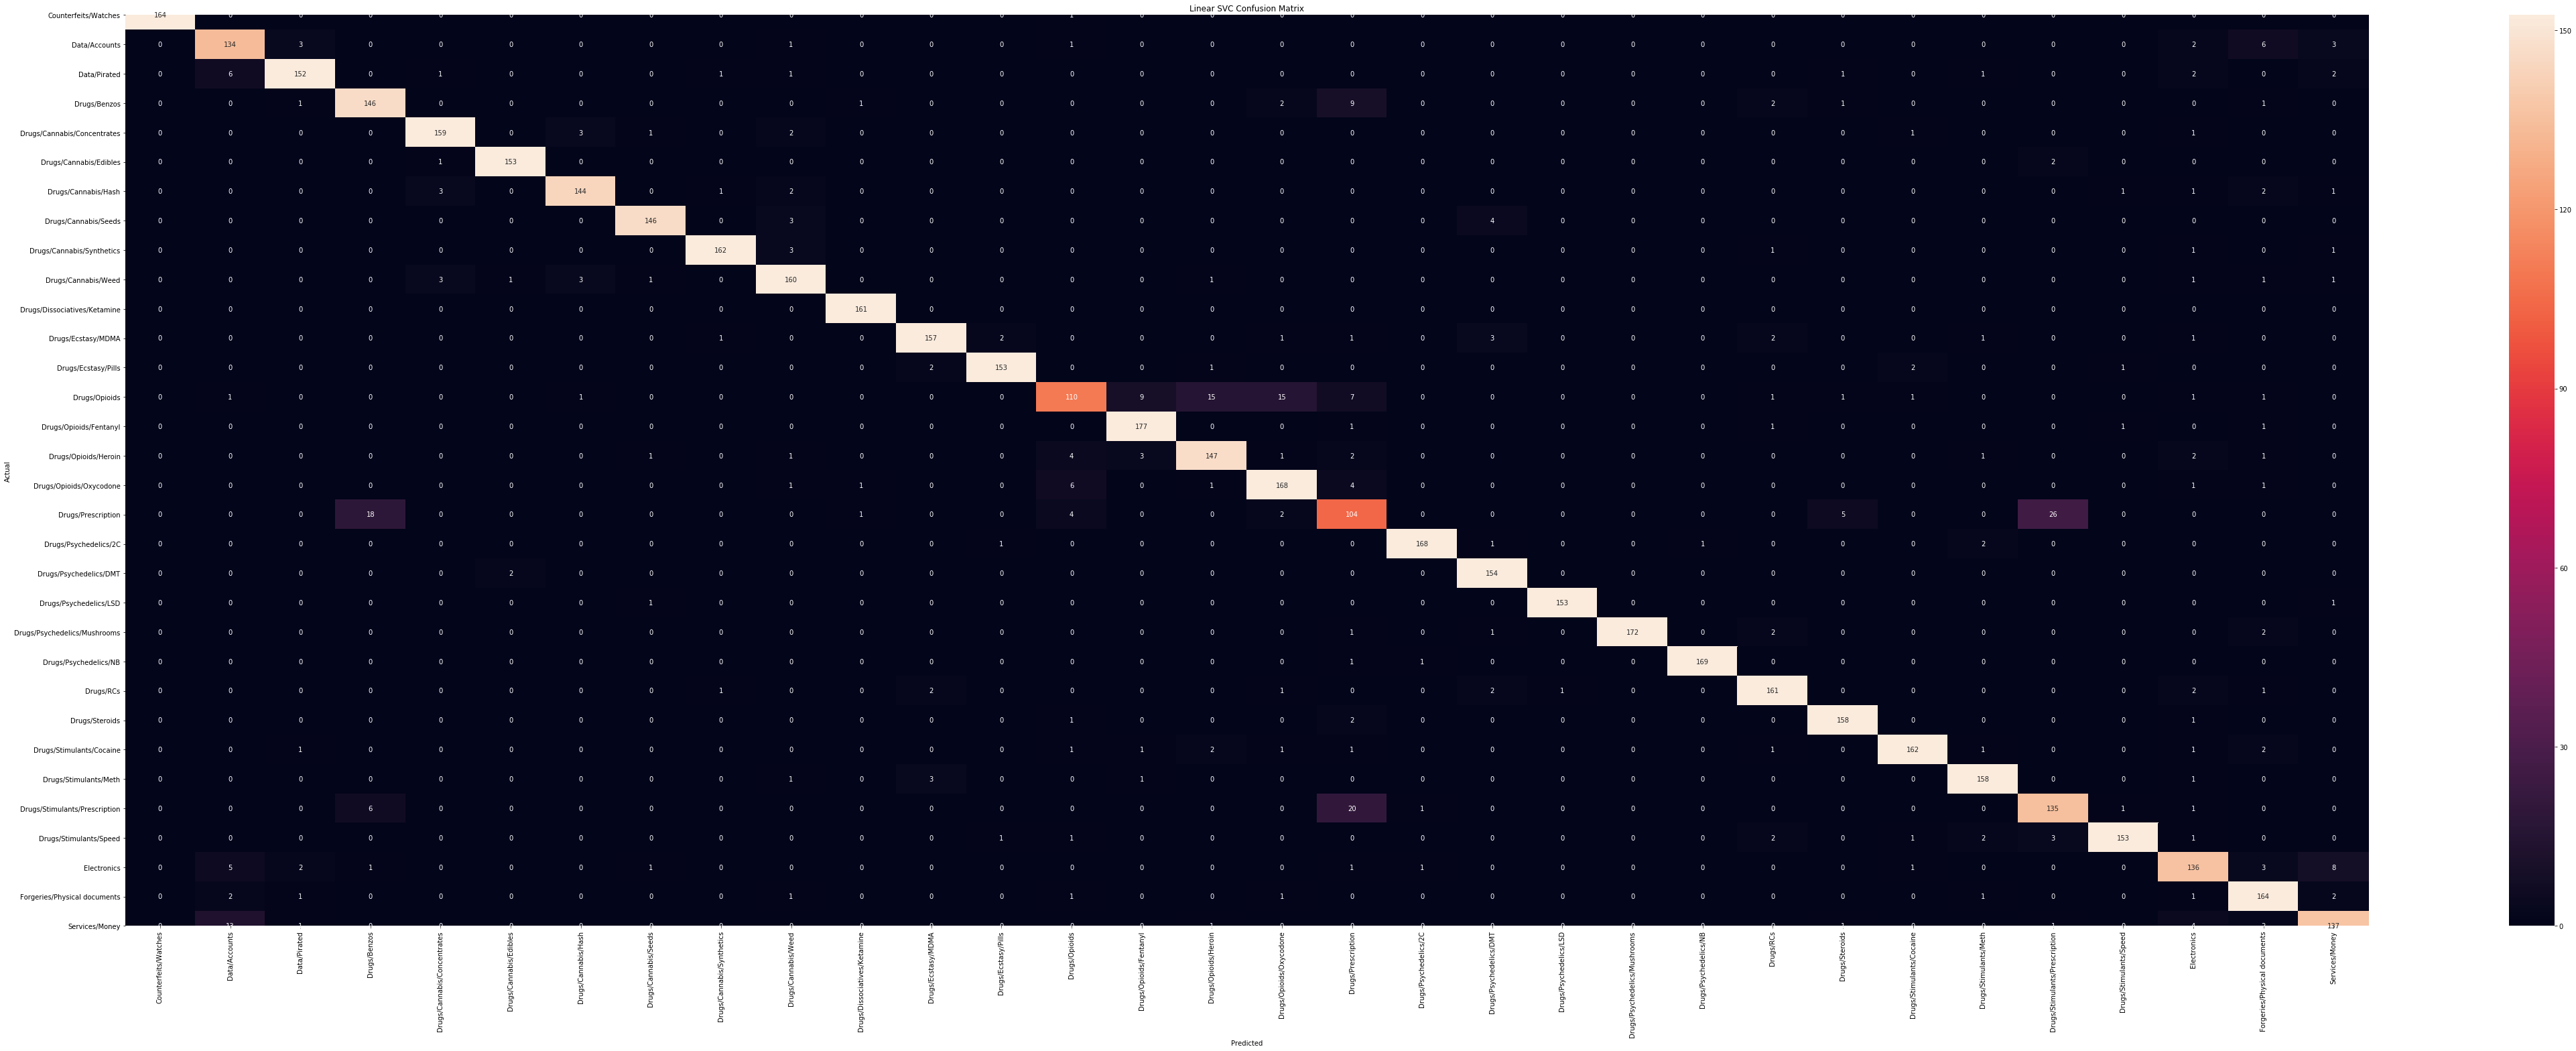

In [5]:
plot_confusion_matrix('Linear SVC', y_predLinearSVC)

In [6]:
print(metrics.classification_report(y_test, y_predLinearSVC, target_names=df['Category'].unique()))

                               precision    recall  f1-score   support

         Counterfeits/Watches       1.00      0.99      1.00       165
                Data/Accounts       0.83      0.89      0.86       150
                 Data/Pirated       0.94      0.91      0.93       167
                 Drugs/Benzos       0.85      0.90      0.87       163
  Drugs/Cannabis/Concentrates       0.95      0.95      0.95       167
       Drugs/Cannabis/Edibles       0.98      0.98      0.98       156
          Drugs/Cannabis/Hash       0.95      0.93      0.94       155
         Drugs/Cannabis/Seeds       0.97      0.95      0.96       153
    Drugs/Cannabis/Synthetics       0.98      0.96      0.97       168
          Drugs/Cannabis/Weed       0.91      0.93      0.92       172
 Drugs/Dissociatives/Ketamine       0.98      1.00      0.99       161
           Drugs/Ecstasy/MDMA       0.96      0.93      0.94       169
          Drugs/Ecstasy/Pills       0.97      0.96      0.97       159
     

### Random Forest Classifier

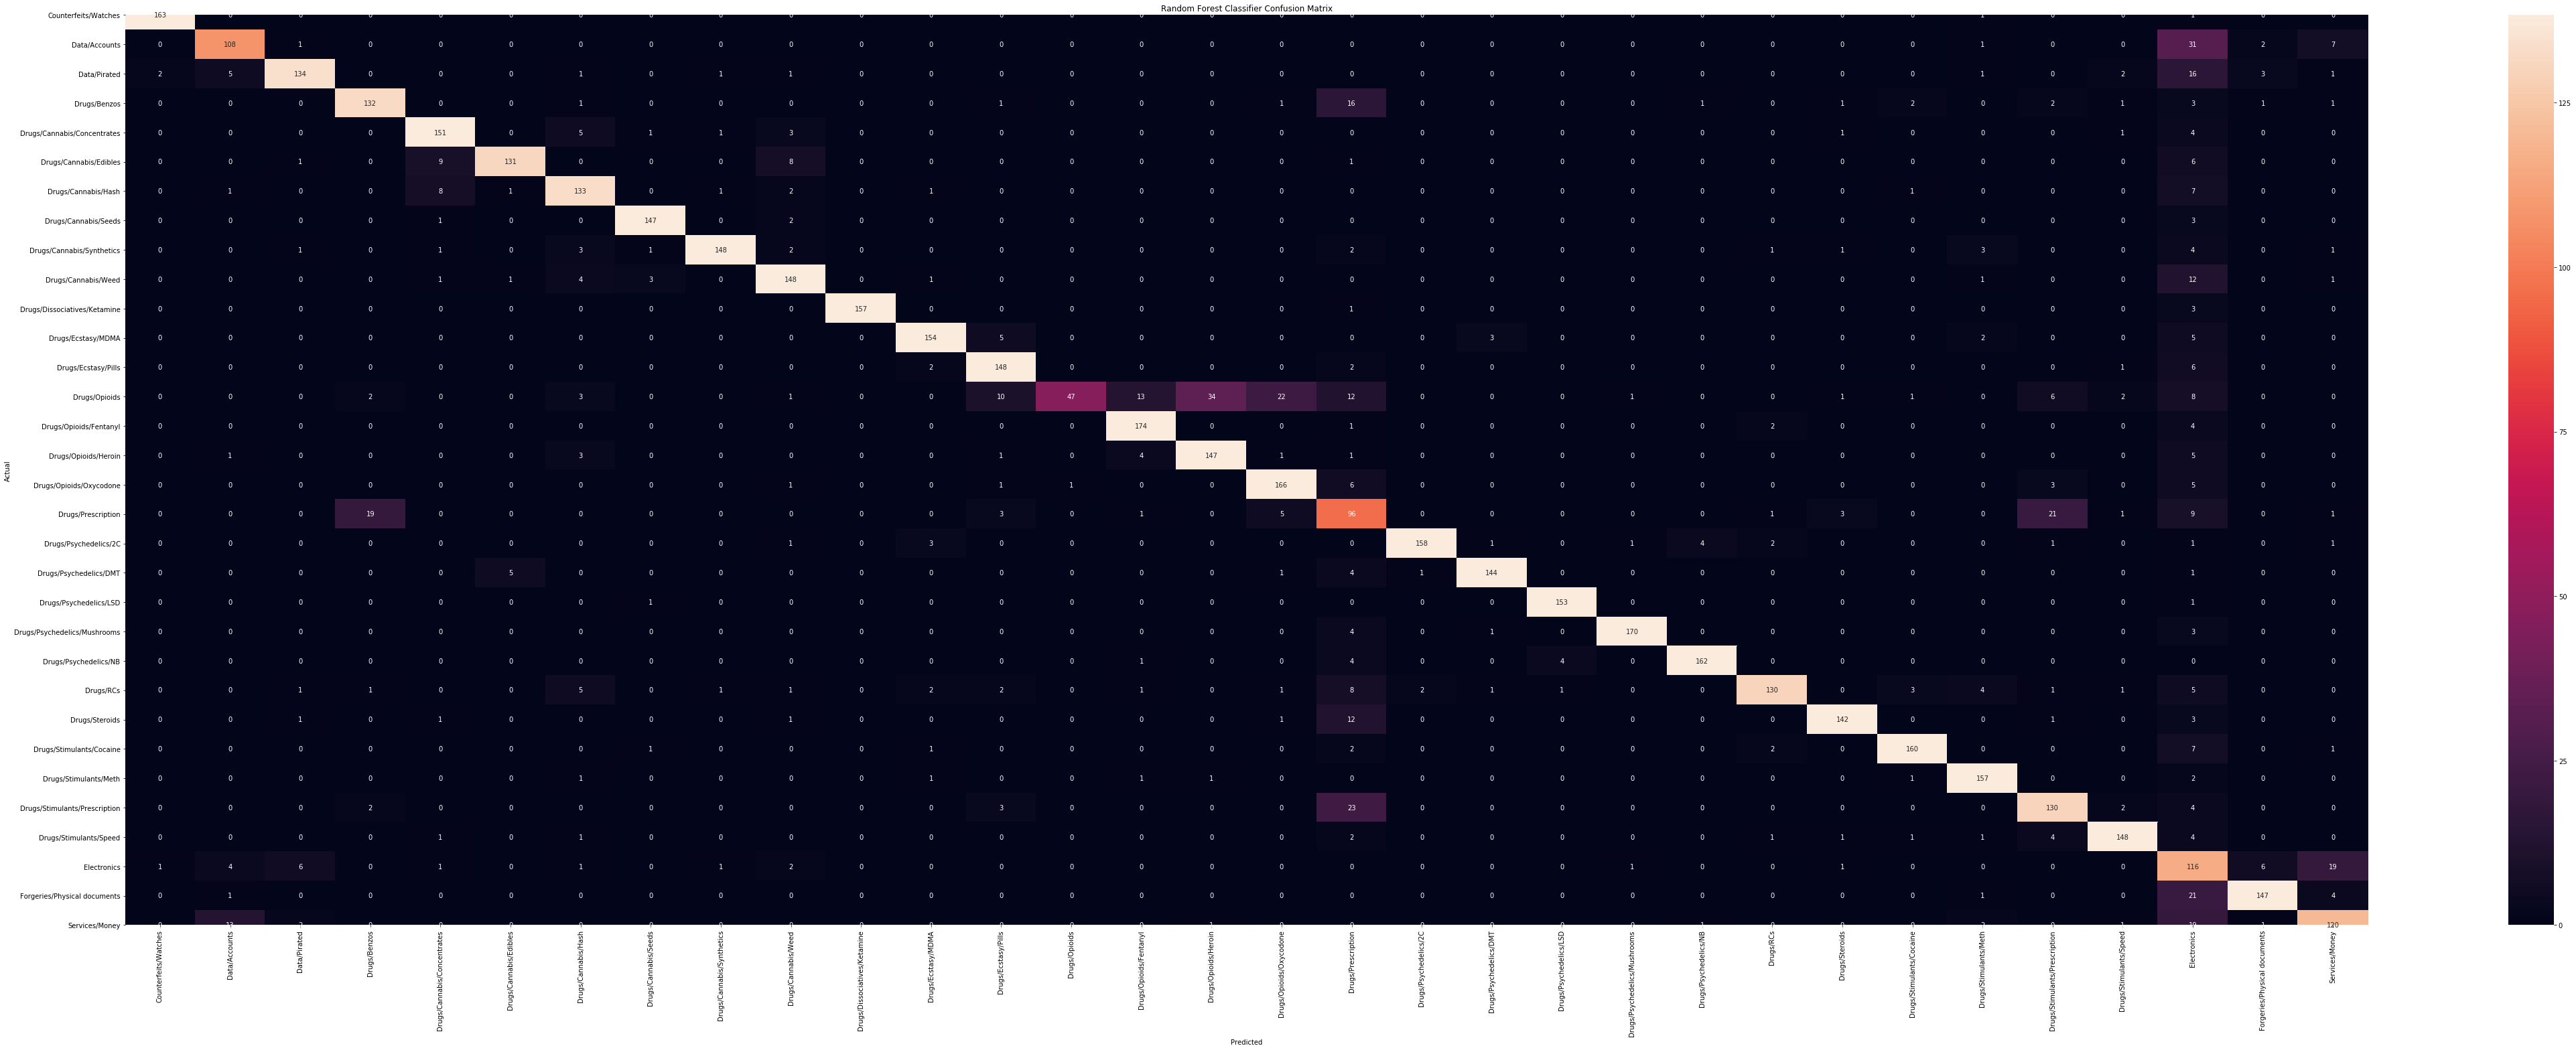

In [7]:
plot_confusion_matrix('Random Forest Classifier', y_predRandomForestClassifier)

In [8]:
print(metrics.classification_report(y_test, y_predRandomForestClassifier, target_names=df['Category'].unique()))

                               precision    recall  f1-score   support

         Counterfeits/Watches       0.98      0.99      0.98       165
                Data/Accounts       0.81      0.72      0.76       150
                 Data/Pirated       0.91      0.80      0.85       167
                 Drugs/Benzos       0.85      0.81      0.83       163
  Drugs/Cannabis/Concentrates       0.87      0.90      0.89       167
       Drugs/Cannabis/Edibles       0.95      0.84      0.89       156
          Drugs/Cannabis/Hash       0.83      0.86      0.84       155
         Drugs/Cannabis/Seeds       0.95      0.96      0.96       153
    Drugs/Cannabis/Synthetics       0.97      0.88      0.92       168
          Drugs/Cannabis/Weed       0.86      0.86      0.86       172
 Drugs/Dissociatives/Ketamine       1.00      0.98      0.99       161
           Drugs/Ecstasy/MDMA       0.93      0.91      0.92       169
          Drugs/Ecstasy/Pills       0.85      0.93      0.89       159
     

### Multinomial Naive Bais

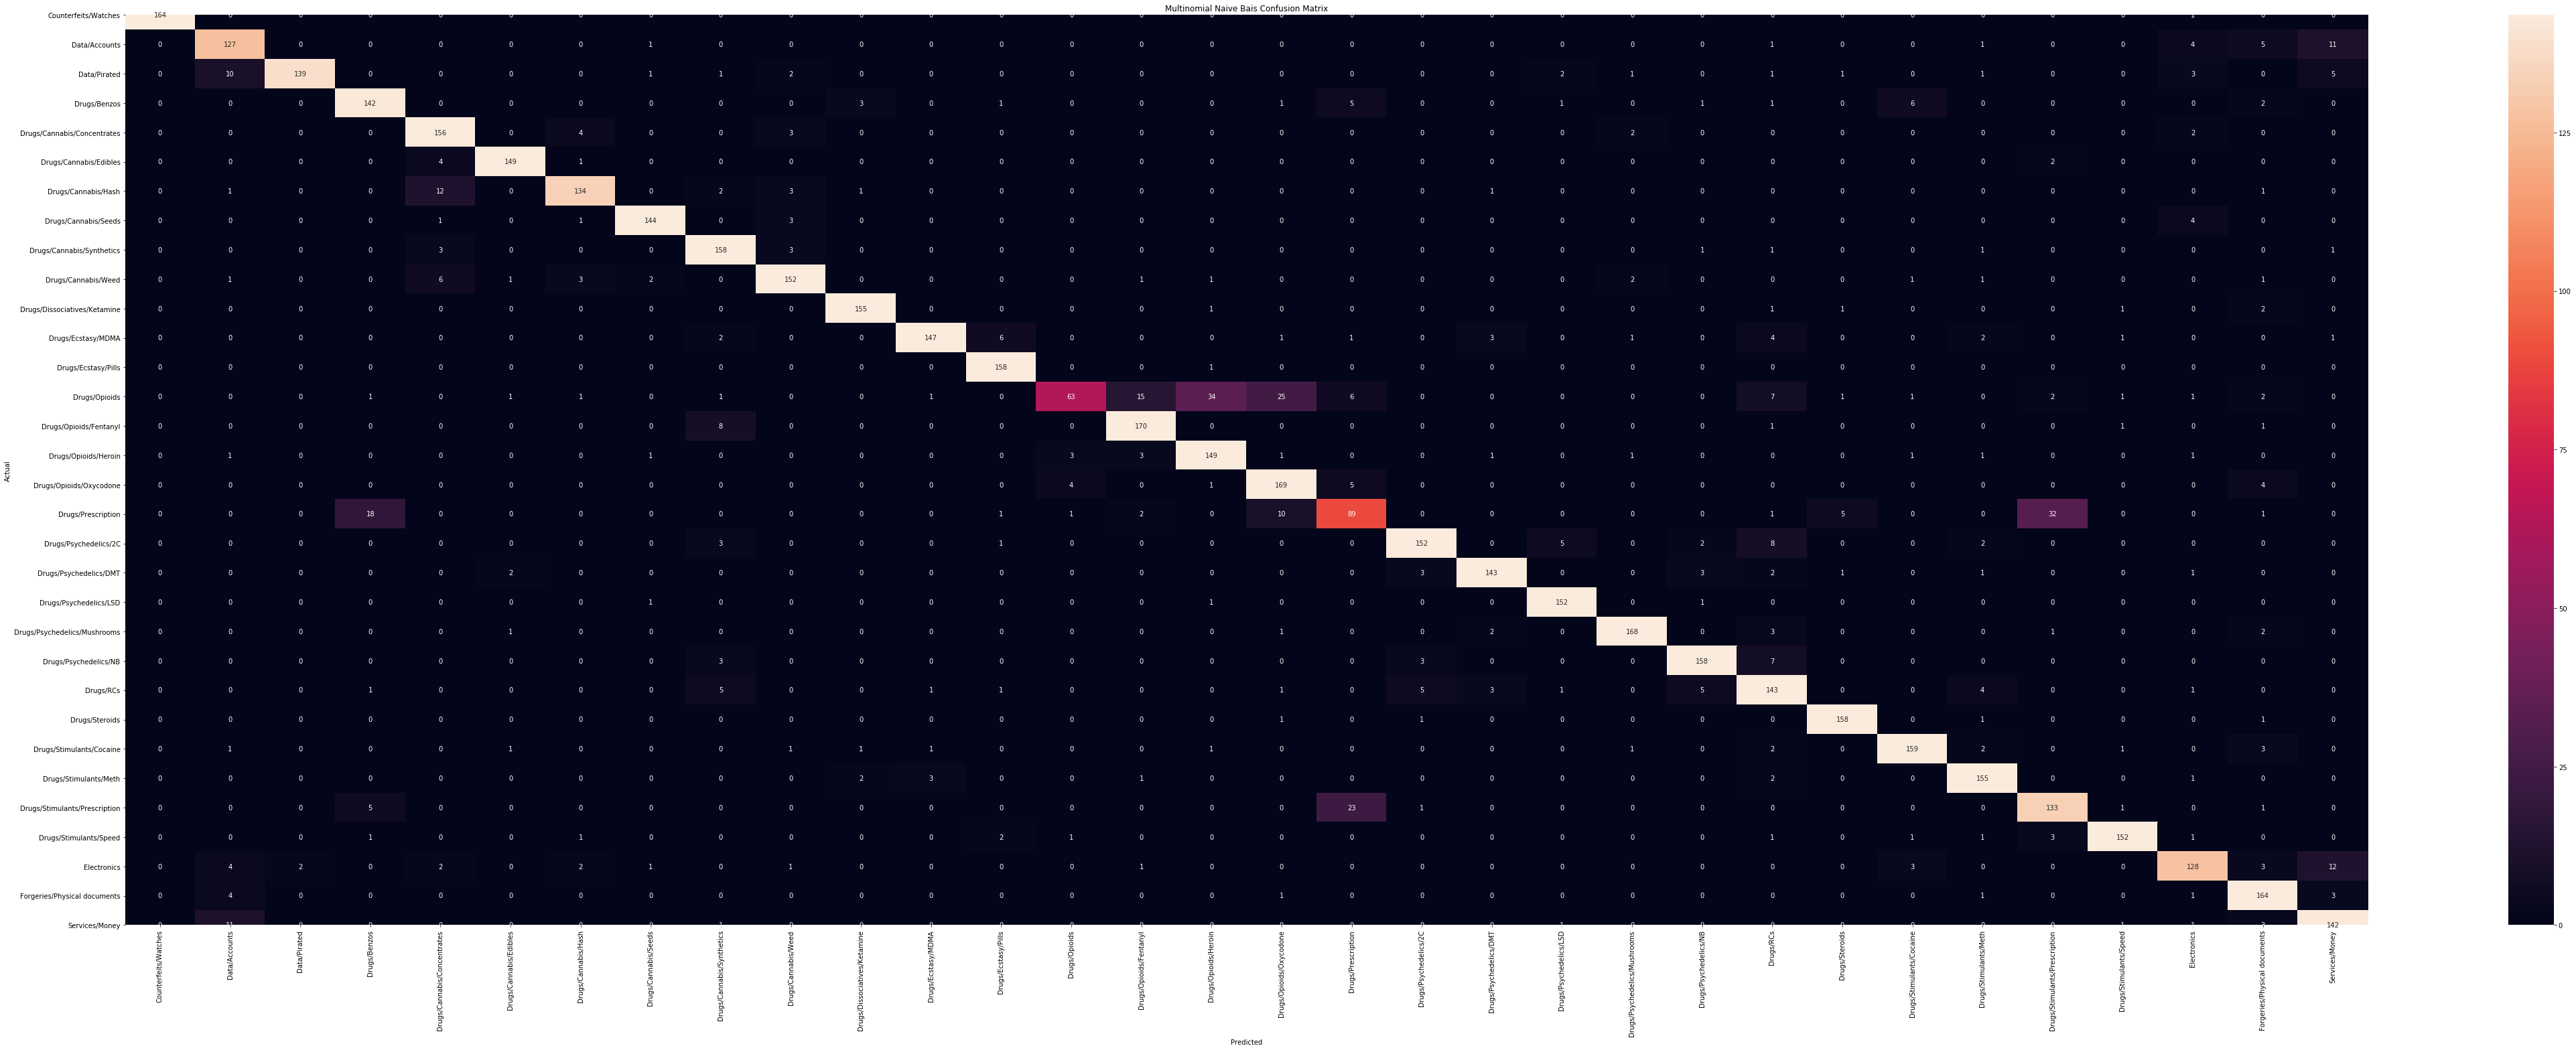

In [9]:
plot_confusion_matrix('Multinomial Naive Bais', y_predMultinomialNB)

In [10]:
print(metrics.classification_report(y_test, y_predMultinomialNB, target_names=df['Category'].unique()))

                               precision    recall  f1-score   support

         Counterfeits/Watches       1.00      0.99      1.00       165
                Data/Accounts       0.79      0.85      0.82       150
                 Data/Pirated       0.99      0.83      0.90       167
                 Drugs/Benzos       0.85      0.87      0.86       163
  Drugs/Cannabis/Concentrates       0.85      0.93      0.89       167
       Drugs/Cannabis/Edibles       0.96      0.96      0.96       156
          Drugs/Cannabis/Hash       0.91      0.86      0.89       155
         Drugs/Cannabis/Seeds       0.95      0.94      0.95       153
    Drugs/Cannabis/Synthetics       0.86      0.94      0.90       168
          Drugs/Cannabis/Weed       0.90      0.88      0.89       172
 Drugs/Dissociatives/Ketamine       0.96      0.96      0.96       161
           Drugs/Ecstasy/MDMA       0.96      0.87      0.91       169
          Drugs/Ecstasy/Pills       0.93      0.99      0.96       159
     

### Logistic Regression

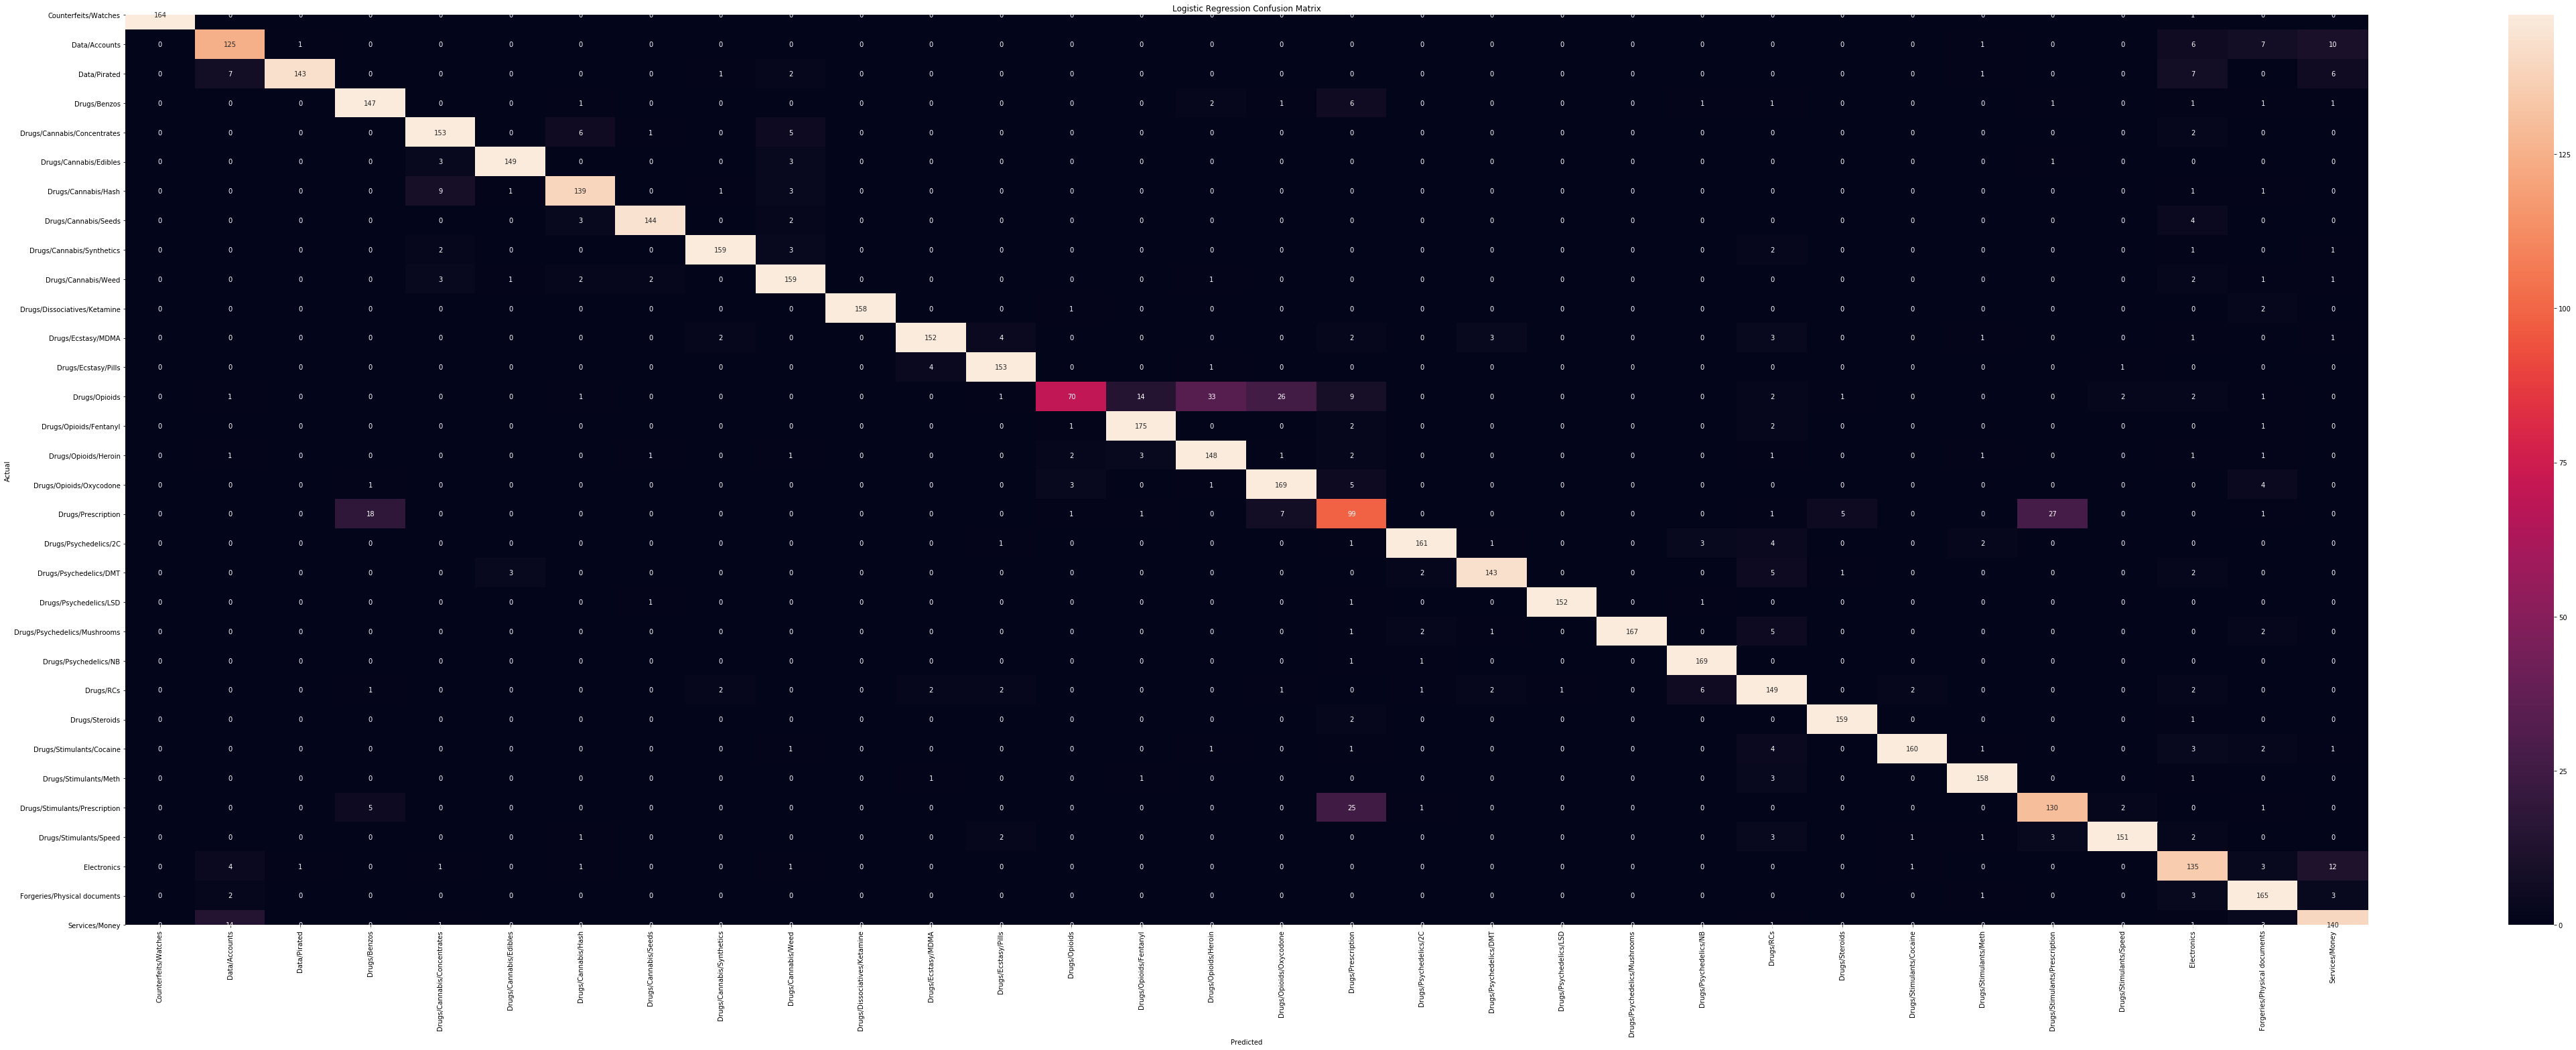

In [11]:
plot_confusion_matrix('Logistic Regression', y_predLogisticRegression)

In [12]:
print(metrics.classification_report(y_test, y_predLogisticRegression, target_names=df['Category'].unique()))

                               precision    recall  f1-score   support

         Counterfeits/Watches       1.00      0.99      1.00       165
                Data/Accounts       0.81      0.83      0.82       150
                 Data/Pirated       0.99      0.86      0.92       167
                 Drugs/Benzos       0.85      0.90      0.88       163
  Drugs/Cannabis/Concentrates       0.89      0.92      0.90       167
       Drugs/Cannabis/Edibles       0.97      0.96      0.96       156
          Drugs/Cannabis/Hash       0.90      0.90      0.90       155
         Drugs/Cannabis/Seeds       0.97      0.94      0.95       153
    Drugs/Cannabis/Synthetics       0.96      0.95      0.95       168
          Drugs/Cannabis/Weed       0.88      0.92      0.90       172
 Drugs/Dissociatives/Ketamine       1.00      0.98      0.99       161
           Drugs/Ecstasy/MDMA       0.96      0.90      0.93       169
          Drugs/Ecstasy/Pills       0.94      0.96      0.95       159
     

### SGD Classifier

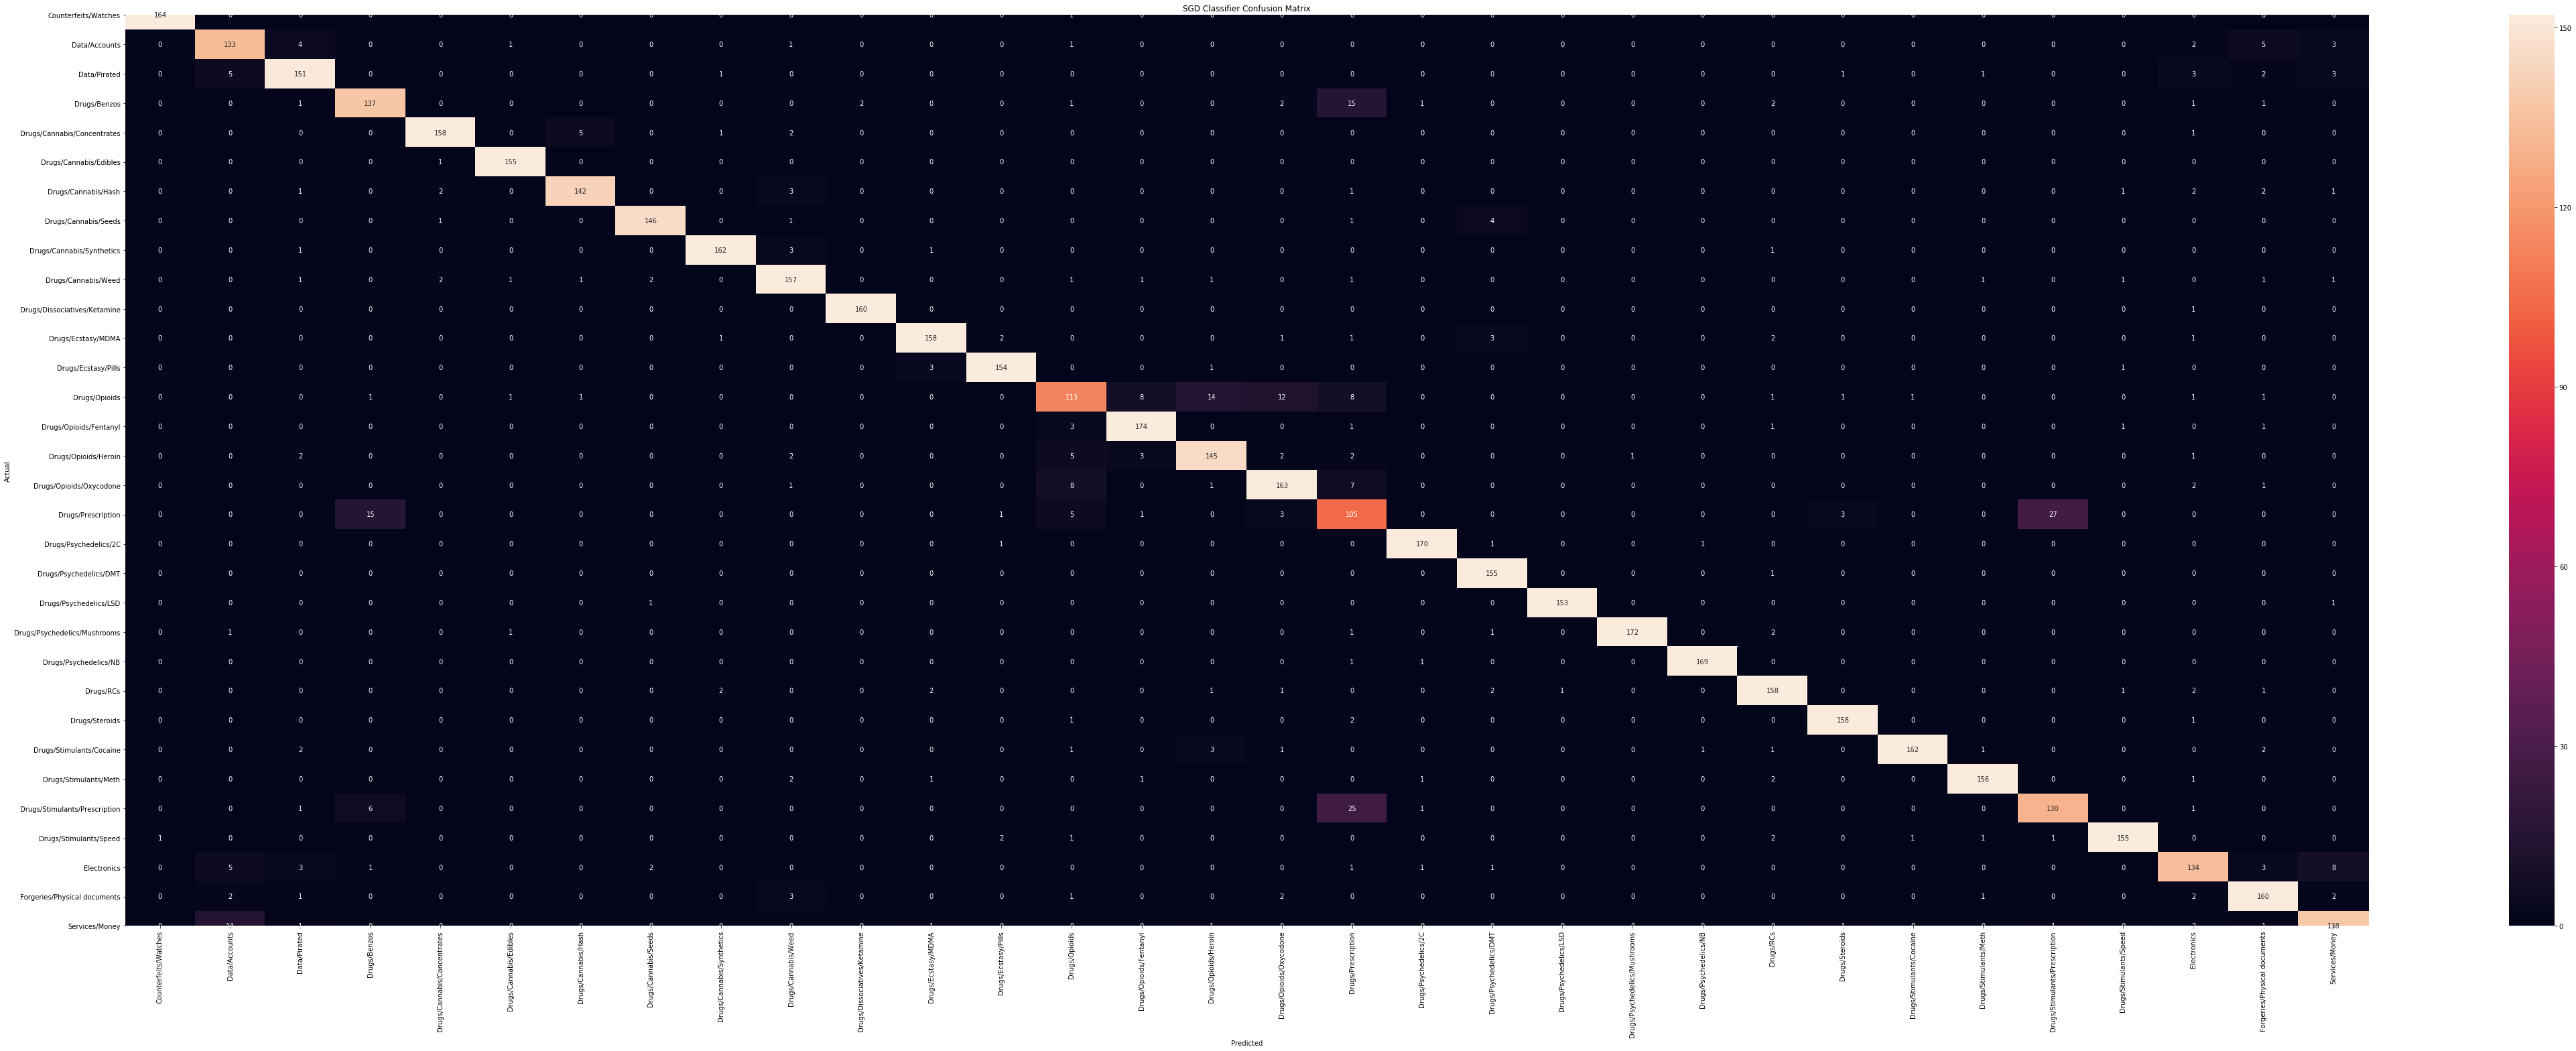

In [13]:
plot_confusion_matrix('SGD Classifier', y_predSGDClassifier)

In [14]:
print(metrics.classification_report(y_test, y_predSGDClassifier, target_names=df['Category'].unique()))

                               precision    recall  f1-score   support

         Counterfeits/Watches       0.99      0.99      0.99       165
                Data/Accounts       0.83      0.89      0.86       150
                 Data/Pirated       0.89      0.90      0.90       167
                 Drugs/Benzos       0.86      0.84      0.85       163
  Drugs/Cannabis/Concentrates       0.96      0.95      0.95       167
       Drugs/Cannabis/Edibles       0.97      0.99      0.98       156
          Drugs/Cannabis/Hash       0.95      0.92      0.93       155
         Drugs/Cannabis/Seeds       0.97      0.95      0.96       153
    Drugs/Cannabis/Synthetics       0.97      0.96      0.97       168
          Drugs/Cannabis/Weed       0.90      0.91      0.90       172
 Drugs/Dissociatives/Ketamine       0.99      0.99      0.99       161
           Drugs/Ecstasy/MDMA       0.95      0.93      0.94       169
          Drugs/Ecstasy/Pills       0.96      0.97      0.97       159
     